# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

To do so, the following steps are performed: 

Data augmentation is applied to artificially increase the size of the data set.

With the data being ready, the model is created. We use a sequential model leading to a feed forward neural network. The model consists of several convolutional layers to detect features in the images, max pooling layers to reduce the dimensionality of the data, and dense layers to learn the classification. The output layer classifies the images as either a Kaninchen or a Feldhase.

The model is configured using the adam optimizer which utilizes both an adaptive learning rate and a momentum term. The adaptive learning rate adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case). The momentum term accelerates the learning process in the right direction and dampens oscillations.

The model is furthermore trained using early stopping to prevent overfitting.

Finally, the model is evaluated based on the test data. Our current accuracy high-score is about 91%.

The comments in this notebook are plenty and generated mostly utilizing the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to understand the code better.

# Imports

In [34]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Implementing data augmentation to artificially increase the size of the data set

In [49]:
# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    vertical_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2,         # Randomly zoom images (range: 0.2 means 20% zoom in/out)
    shear_range=0.2,        # Randomly shear images
    rotation_range=10,      # Randomly rotate images by up to 10 degrees
    fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel
)

# Load your dataset using tf.keras.utils.image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory('photos')

# Create lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each batch of data
for images, labels in data:
    # Loop through each image in the batch
    for i in range(len(images)):
        image_np = images[i].numpy()  # Convert TensorFlow tensor to NumPy array
        augmented_images.append(image_np)  # Original image
        augmented_labels.append(labels[i])

        # Apply data augmentation multiple times (e.g., 3 times)
        for _ in range(4):
            augmented_image = datagen.random_transform(image_np)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

# Convert lists to NumPy arrays and normalize
augmented_images = np.array(augmented_images) / 255.0
augmented_labels = np.array(augmented_labels)

# Create a new dataset with augmented data
augmented_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Shuffle the dataset and set batch size
augmented_data = augmented_data.shuffle(len(augmented_images))


Found 480 files belonging to 2 classes.


In [50]:
# Calculate the number of images and classes in the dataset
num_images = len(augmented_images)  # Number of images is determined by the length of the augmented_images array
num_classes = len(np.unique(augmented_labels))  # Number of classes is determined by the number of unique labels in the augmented_labels array
# Print the calculated values
print(f"Number of images: {num_images}")  # Print the number of images
print(f"Number of classes: {num_classes}")  # Print the number of classes


Number of images: 2400
Number of classes: 2


# Train/Test Split

In [51]:
# Split the data into training and testing sets
# augmented_images: The input images data
# augmented_labels: The corresponding labels for the images
# test_size=0.2: Specifies that 20% of the data will be used for testing, while 80% will be used for training
# random_state=42: Sets the seed for the random number generator to ensure reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

# Create the model

In [52]:
# Define the architecture of the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),  # Convolutional layer with 16 filters, each of size 3x3, using ReLU activation function. Input shape is 256x256 pixels with 3 channels (RGB).
    tf.keras.layers.MaxPool2D(),  # Max pooling layer to downsample the feature maps.
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),  # Second convolutional layer with 32 filters and ReLU activation.
    tf.keras.layers.MaxPool2D(),  # Max pooling layer.
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu'),  # Third convolutional layer with 16 filters and ReLU activation.
    tf.keras.layers.MaxPooling2D(),  # Max pooling layer.
    tf.keras.layers.Flatten(),  # Flatten layer to convert the 2D feature maps into a 1D feature vector.
    tf.keras.layers.Dense(256, activation='relu'),  # Fully connected dense layer with 256 neurons and ReLU activation.
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification.
])

# Display the summary of the model architecture, including the number of parameters in each layer.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

# Configuring the neural network model
In using the adam optimizer, we utilize both an adaptive learning rate and a momentum term. The adaptive learning rate adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case). The momentum term accelerates the learning process in the right direction and dampens oscillations

In [53]:
# Compile the model
# optimizer='adam': Specifies the Adam optimizer as the optimization algorithm for training the model. Adam is an adaptive learning rate optimization algorithm that is well-suited for training deep neural networks.
# loss='binary_crossentropy': Specifies binary cross-entropy as the loss function to be minimized during training. Binary cross-entropy is commonly used for binary classification problems.
# metrics=['accuracy']: Specifies that the accuracy metric should be computed and displayed during training and evaluation of the model. Accuracy is a commonly used metric for classification tasks, measuring the proportion of correctly predicted samples.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Implement learning rate scheduler
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Configure early stopping callback
# monitor='val_loss': Specifies that the validation loss will be monitored during training to determine when to stop early. Training will stop if the validation loss does not improve for a certain number of epochs.
# patience=3: Specifies the number of epochs with no improvement in validation loss before training is stopped. In this case, training will stop after 3 consecutive epochs with no improvement in validation loss.
# restore_best_weights=True: Specifies that the model weights from the epoch with the lowest validation loss will be restored at the end of training. This ensures that the model retains the best performance observed during training.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Create cross validation folds + train the model for each fold (with early stopping)

In [55]:
# Define the number of folds for cross-validation
num_folds = 2

# Initialize KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
acc_per_fold = []  # Accuracy for each fold
loss_per_fold = []  # Loss for each fold

# List to store training history for each fold
histories = []

# Initialize fold counter
fold_no = 1

# Iterate over each fold
for train, val in kfold.split(X_train, y_train):
    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Fit the model to the training data for the current fold, using early stopping
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size= 64, callbacks=[early_stopping])
    
    # Save the training history for later plotting
    histories.append(history)
    
    # Increment fold counter
    fold_no += 1


Epoch 1/20
15/15 [==============================] - 34s 1s/step - loss: 0.8633 - accuracy: 0.5010 - val_loss: 0.6641 - val_accuracy: 0.6667
Epoch 2/20
15/15 [==============================] - 7s 446ms/step - loss: 0.6418 - accuracy: 0.6490 - val_loss: 0.6188 - val_accuracy: 0.6521
Epoch 3/20
15/15 [==============================] - 7s 443ms/step - loss: 0.5485 - accuracy: 0.7208 - val_loss: 0.5295 - val_accuracy: 0.7552
Epoch 4/20
15/15 [==============================] - 7s 443ms/step - loss: 0.4779 - accuracy: 0.7729 - val_loss: 0.4586 - val_accuracy: 0.7771
Epoch 5/20
15/15 [==============================] - 7s 443ms/step - loss: 0.3998 - accuracy: 0.8167 - val_loss: 0.3951 - val_accuracy: 0.8125
Epoch 6/20
15/15 [==============================] - 7s 440ms/step - loss: 0.3544 - accuracy: 0.8385 - val_loss: 0.3828 - val_accuracy: 0.8271
Epoch 7/20
15/15 [==============================] - 6s 438ms/step - loss: 0.2803 - accuracy: 0.8802 - val_loss: 0.4229 - val_accuracy: 0.8135
Epoch 8/

In [56]:
# Evaluate the trained model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Print the test accuracy
print(f'Test accuracy: {test_acc}')


15/15 - 1s - loss: 0.2681 - accuracy: 0.9042 - 971ms/epoch - 65ms/step
Test accuracy: 0.9041666388511658


# Assess the average performance of the model across all folds

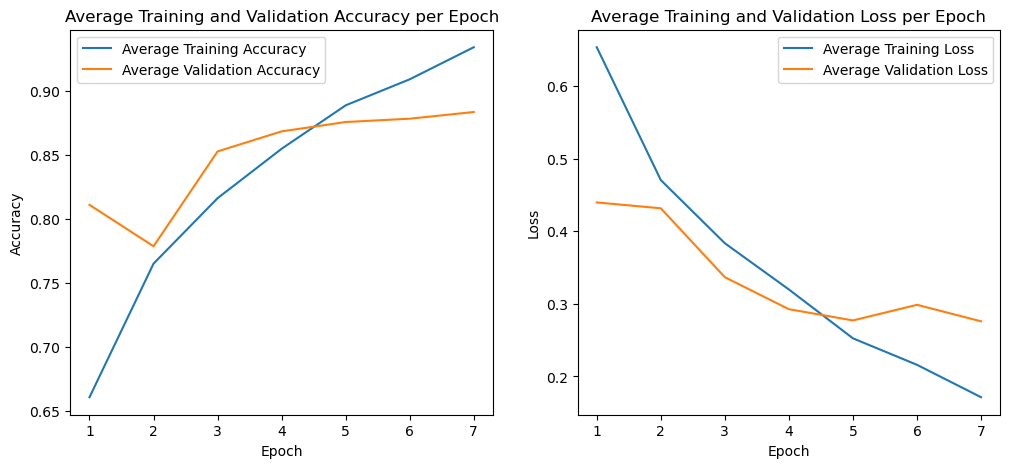

In [57]:
# Find the minimum number of epochs among all folds to enable equal plotting
min_epochs = min([len(history.history['accuracy']) for history in histories])

# Initialize arrays for averaged metrics with the size of the minimum number of epochs
avg_train_acc = np.zeros(min_epochs)
avg_val_acc = np.zeros(min_epochs)
avg_train_loss = np.zeros(min_epochs)
avg_val_loss = np.zeros(min_epochs)

# Sum up the metrics for the minimum epoch range across all folds
for history in histories:
    avg_train_acc += np.array(history.history['accuracy'][:min_epochs])
    avg_val_acc += np.array(history.history['val_accuracy'][:min_epochs])
    avg_train_loss += np.array(history.history['loss'][:min_epochs])
    avg_val_loss += np.array(history.history['val_loss'][:min_epochs])

# Compute the average
# The average is choosen as it provides a more generalized evaliation of the models performance
avg_train_acc /= len(histories)
avg_val_acc /= len(histories)
avg_train_loss /= len(histories)
avg_val_loss /= len(histories)


# Plotting
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_epochs+1), avg_train_acc, label='Average Training Accuracy')
plt.plot(range(1, min_epochs+1), avg_val_acc, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_epochs+1), avg_train_loss, label='Average Training Loss')
plt.plot(range(1, min_epochs+1), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Assess the average performance of the model across for each fold

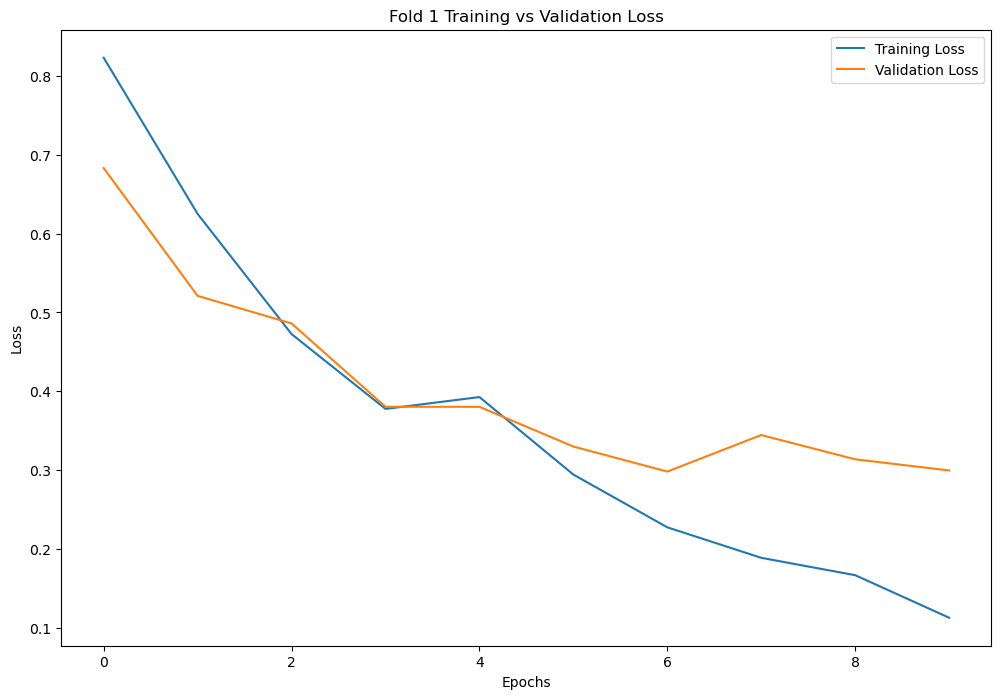

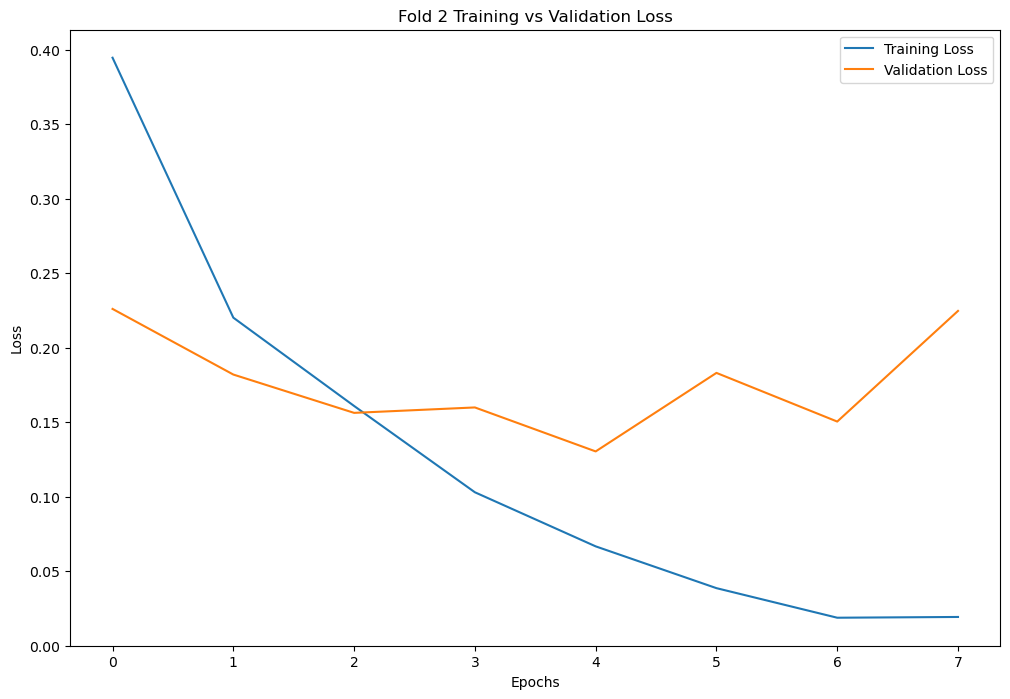

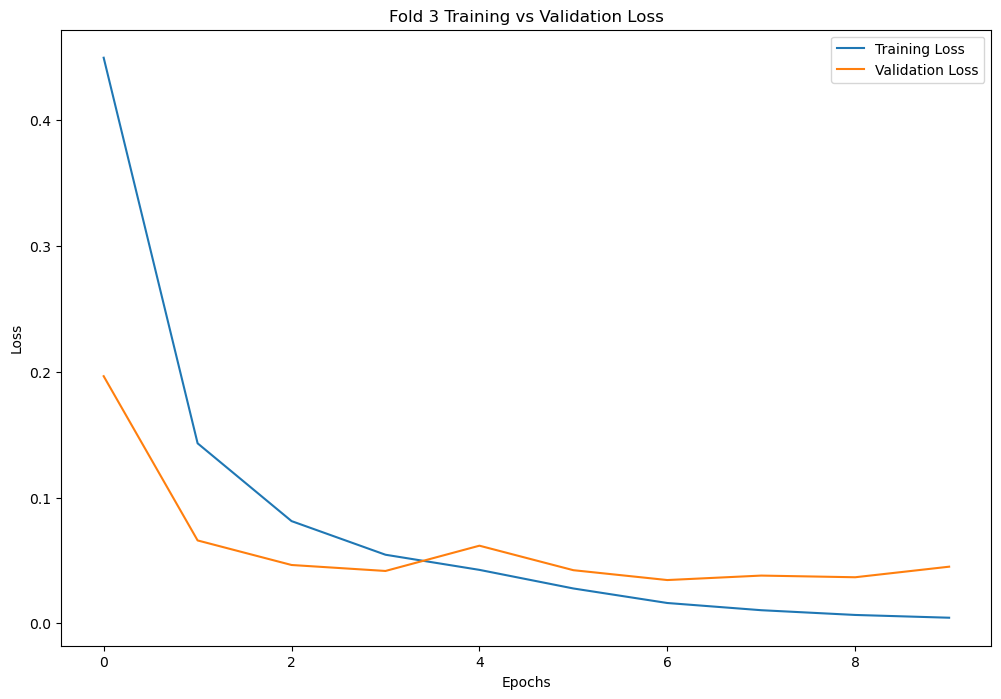

In [43]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [32]:
model.save("classification_model.h5")

P:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
